### Ứng dụng các thuật toán phân cụm để phân đoạn khách hàng
---

#### I. Khai báo bộ dữ liệu và các thư viện cần thiết
#### II. Tiến hành xây dựng các mô hình phân cụm
#####    1. Thuật toán K - Means Clustering
#####    2. Thuật toán Hierachical Clustering
#####    3. Thuật toán DBSCAN
#### III. Kết luận

---

# I. KHAI BÁO BỘ DỮ LIỆU VÀ CÁC THƯ VIỆN CẦN THIẾT:

## 1. Khai báo các thư viện

In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected = True)
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

## 2. Đọc bộ dữ liệu

In [124]:
file_path = r"C:\Users\LENOVO\Downloads\Telco_Churn_dataset.xlsx"
data = pd.read_excel(file_path)

## 3. Kiểm tra dữ liệu

In [125]:
data.head(3)

customerID  gender  SeniorCitizen Partner Dependents  Age  tenure  \
0  7590-VHVEG  Female              0     Yes         No   34       1   
1  5575-GNVDE    Male              0      No         No   27      34   
2  3668-QPYBK    Male              0      No         No   36       2   

  PhoneService     MultipleLines InternetService  ... StreamingTV  \
0           No  No phone service             DSL  ...          No   
1          Yes                No             DSL  ...          No   
2          Yes                No             DSL  ...          No   

  StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
0              No  Month-to-month              Yes  Electronic check   
1              No        One year               No      Mailed check   
2              No  Month-to-month              Yes      Mailed check   

  MonthlyCharges TotalCharges numAdminTickets numTechTickets  Churn  
0          29.85        29.85               0              0     No  
1          56.95       1889.5               0              0     No  
2          53.85       108.15               0              0    Yes  

[3 rows x 24 columns]

In [126]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
Age                   int64
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
numAdminTickets       int64
numTechTickets        int64
Churn                object
dtype: object

## 4. Chọn đặc trưng phân cụm:
    + Dữ liệu kiểu số
    + Không chứa dữ liệu Boolean 0-1
    + Không bị mất cân bằng

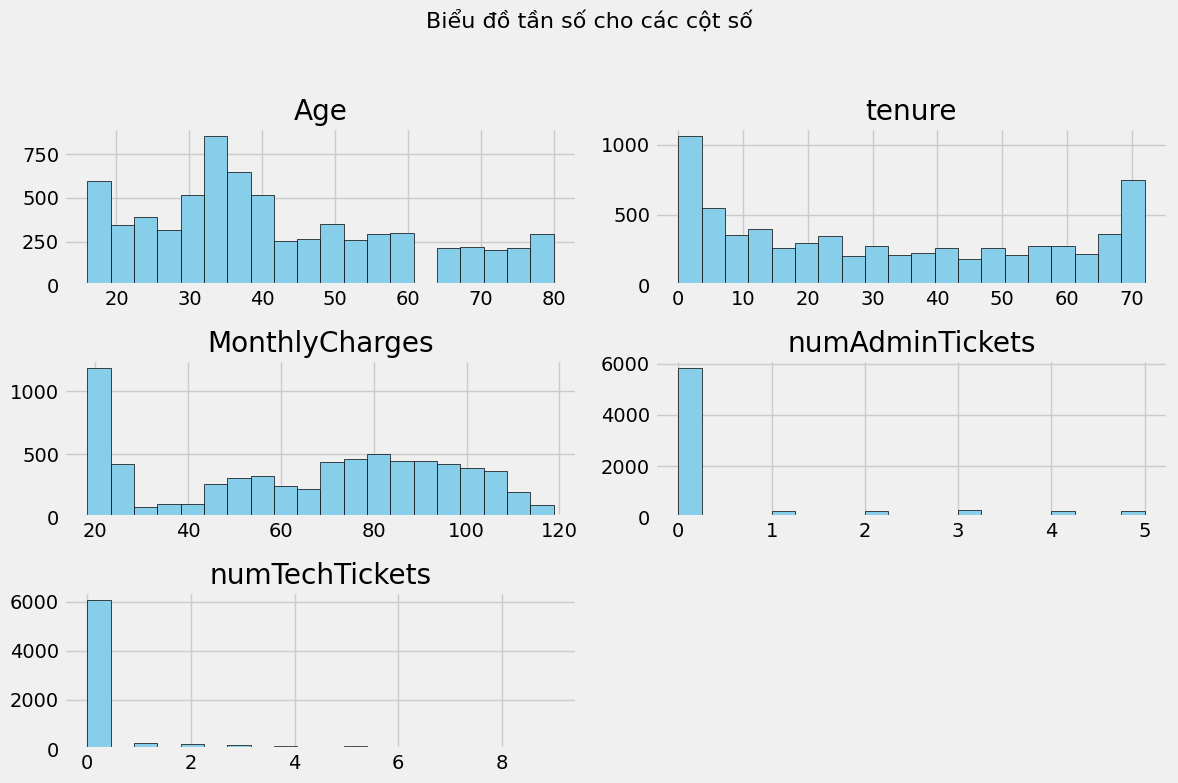

In [127]:
# Đọc dữ liệu từ file
numerical_features = data.select_dtypes(include=['float64', 'int64'])
# Loại bỏ các cột chỉ chứa giá trị 0 và 1
numerical_features = numerical_features.loc[:, numerical_features.nunique() > 2]
# Loại bỏ giá trị null
data = data.dropna()
# Vẽ biểu đồ tần số cho các cột được lọc
numerical_features.hist(figsize=(12, 8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Biểu đồ tần số cho các cột số", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.grid(True)
plt.show()

In [129]:
#Loại 2 cột không phù hợp chuẩn hoá dữ liệu
from sklearn.preprocessing import StandardScaler
numerical_features = numerical_features.drop(columns=['numAdminTickets', 'numTechTickets'], errors='ignore')
numerical_features = numerical_features.dropna()
scaler = StandardScaler()
score_normalized_data = scaler.fit_transform(numerical_features)

# II. TIẾN HÀNH CÁC MÔ HÌNH PHÂN CỤM:

## 1. Thuật toán K-Means

### a. Chọn số cụm tối ưu với phương pháp Elbow và biểu đồ Silhouette Score

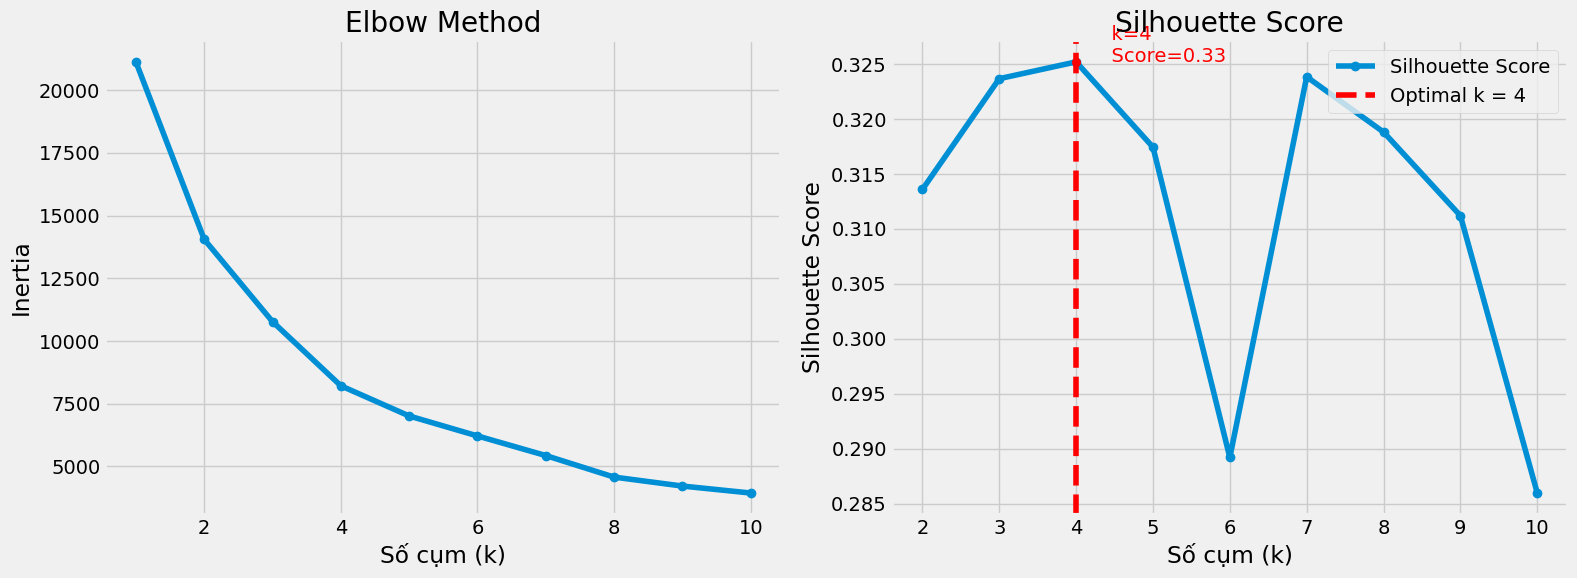

In [130]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Tính toán Elbow Method
inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(score_normalized_data)
    inertia.append(kmeans.inertia_)

# Tính toán Silhouette Score
silhouette_scores = []
range_clusters_silhouette = range(2, 11)  # Bắt đầu từ 2 cụm

for k in range_clusters_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(score_normalized_data)
    silhouette_scores.append(silhouette_score(score_normalized_data, labels))

# Xác định số cụm tối ưu theo Silhouette Score
max_index = silhouette_scores.index(max(silhouette_scores))
optimal_k = list(range_clusters_silhouette)[max_index]
max_score = max(silhouette_scores)

# Tạo 2 biểu đồ cạnh nhau
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ Elbow Method
axs[0].plot(range_clusters, inertia, marker='o')
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Số cụm (k)')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

# Biểu đồ Silhouette Score
axs[1].plot(range_clusters_silhouette, silhouette_scores, marker='o', label='Silhouette Score')
axs[1].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
axs[1].scatter(optimal_k, max_score, color='red', zorder=5)
axs[1].text(optimal_k + 0.3, max_score, f"  k={optimal_k}\n  Score={max_score:.2f}", color='red')
axs[1].set_title('Silhouette Score')
axs[1].set_xlabel('Số cụm (k)')
axs[1].set_ylabel('Silhouette Score')
axs[1].legend()
axs[1].grid(True)

# Hiển thị 2 biểu đồ
plt.tight_layout()
plt.show()


### b. Chọn K = 4 và thực hiện phân cụm

In [131]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(score_normalized_data)
labels = kmeans.labels_

# Thêm giá trị cụm vào cột Cluster
data['Cluster'] = labels

# Số lần thay đổi tâm cụm
num_iterations = kmeans.n_iter_
print("Số lần thay đổi tâm cụm:", num_iterations)


Số lần thay đổi tâm cụm: 16


In [132]:
data.head(4)

customerID  gender  SeniorCitizen Partner Dependents  Age  tenure  \
0  7590-VHVEG  Female              0     Yes         No   34       1   
1  5575-GNVDE    Male              0      No         No   27      34   
2  3668-QPYBK    Male              0      No         No   36       2   
3  7795-CFOCW    Male              0      No         No   27      45   

  PhoneService     MultipleLines InternetService  ... StreamingMovies  \
0           No  No phone service             DSL  ...              No   
1          Yes                No             DSL  ...              No   
2          Yes                No             DSL  ...              No   
3           No  No phone service             DSL  ...              No   

         Contract PaperlessBilling              PaymentMethod MonthlyCharges  \
0  Month-to-month              Yes           Electronic check          29.85   
1        One year               No               Mailed check          56.95   
2  Month-to-month              Yes               Mailed check          53.85   
3        One year               No  Bank transfer (automatic)          42.30   

  TotalCharges numAdminTickets numTechTickets Churn  Cluster  
0        29.85               0              0    No        2  
1       1889.5               0              0    No        3  
2       108.15               0              0   Yes        3  
3      1840.75               0              3    No        2  

[4 rows x 25 columns]

### c. Biểu đồ phân tán cho mô hình trên

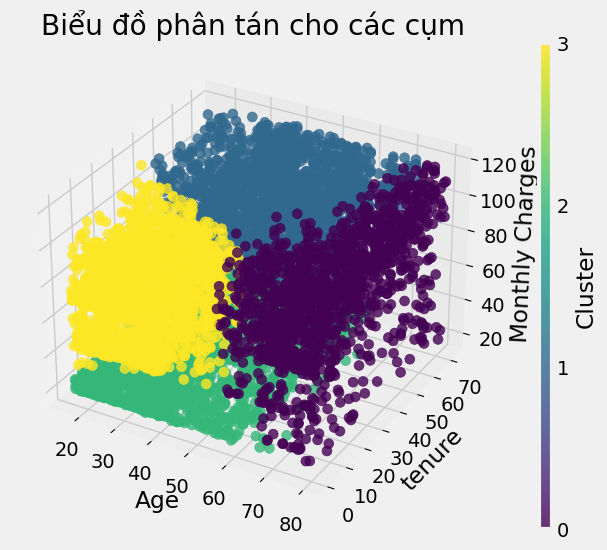

In [24]:
# Tạo biểu đồ 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
# Vẽ từng cụm theo màu
scatter = ax.scatter(
    data['Age'], 
    data['tenure'], 
    data['MonthlyCharges'],    
    c=data['Cluster'],   # Màu theo cụm
    cmap='viridis',      # Dùng bảng màu
    s=50,                # Kích thước điểm
    alpha=0.8            # Độ trong suốt
)
# Gắn nhãn các trục
ax.set_xlabel('Age')
ax.set_ylabel('tenure')
ax.set_zlabel('Monthly Charges')
# Thêm tiêu đề
ax.set_title('Biểu đồ phân tán cho các cụm')
# Hiển thị thanh màu (legend)
cbar = fig.colorbar(scatter, ax=ax, ticks=[0, 1, 2, 3], aspect=40)  # Chỉ định các giá trị cụ thể
cbar.set_label('Cluster')
# Hiển thị biểu đồ
plt.show()

trace1 = go.Scatter3d(
    x= data['Age'],
    y= data['tenure'],
    z= data['MonthlyCharges'],
    mode='markers',
    marker=dict(
        size=7,  # Kích thước điểm nhỏ
        color=data['Cluster'],  
        colorscale='Viridis', 
        colorbar=dict(title='Cluster'),
        line=dict(width=0),  # Không viền
        opacity=0.8
    )
)
data = [trace1]
layout = go.Layout(
    title='Clusters ',
    width=650,  # Chiều rộng của biểu đồ
    height=600,  # Chiều cao của biểu đồ
    scene=dict(
        xaxis=dict(title='Age'),
        yaxis=dict(title='tenure'),
        zaxis=dict(title='MonthlyCharges')
    )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### d. Đánh giá chất lượng phân cụm tại K = 4

+ Các chỉ số

WSS (Within-Cluster Sum of Squares): 8214.7432
BSS (Between-Cluster Sum of Squares): 12914.0873
Silhouette Score for K = 4: 0.3252
Calinski-Harabasz Index for K = 4: 3688.6582
Davies-Bouldin Index for K = 4: 1.0741


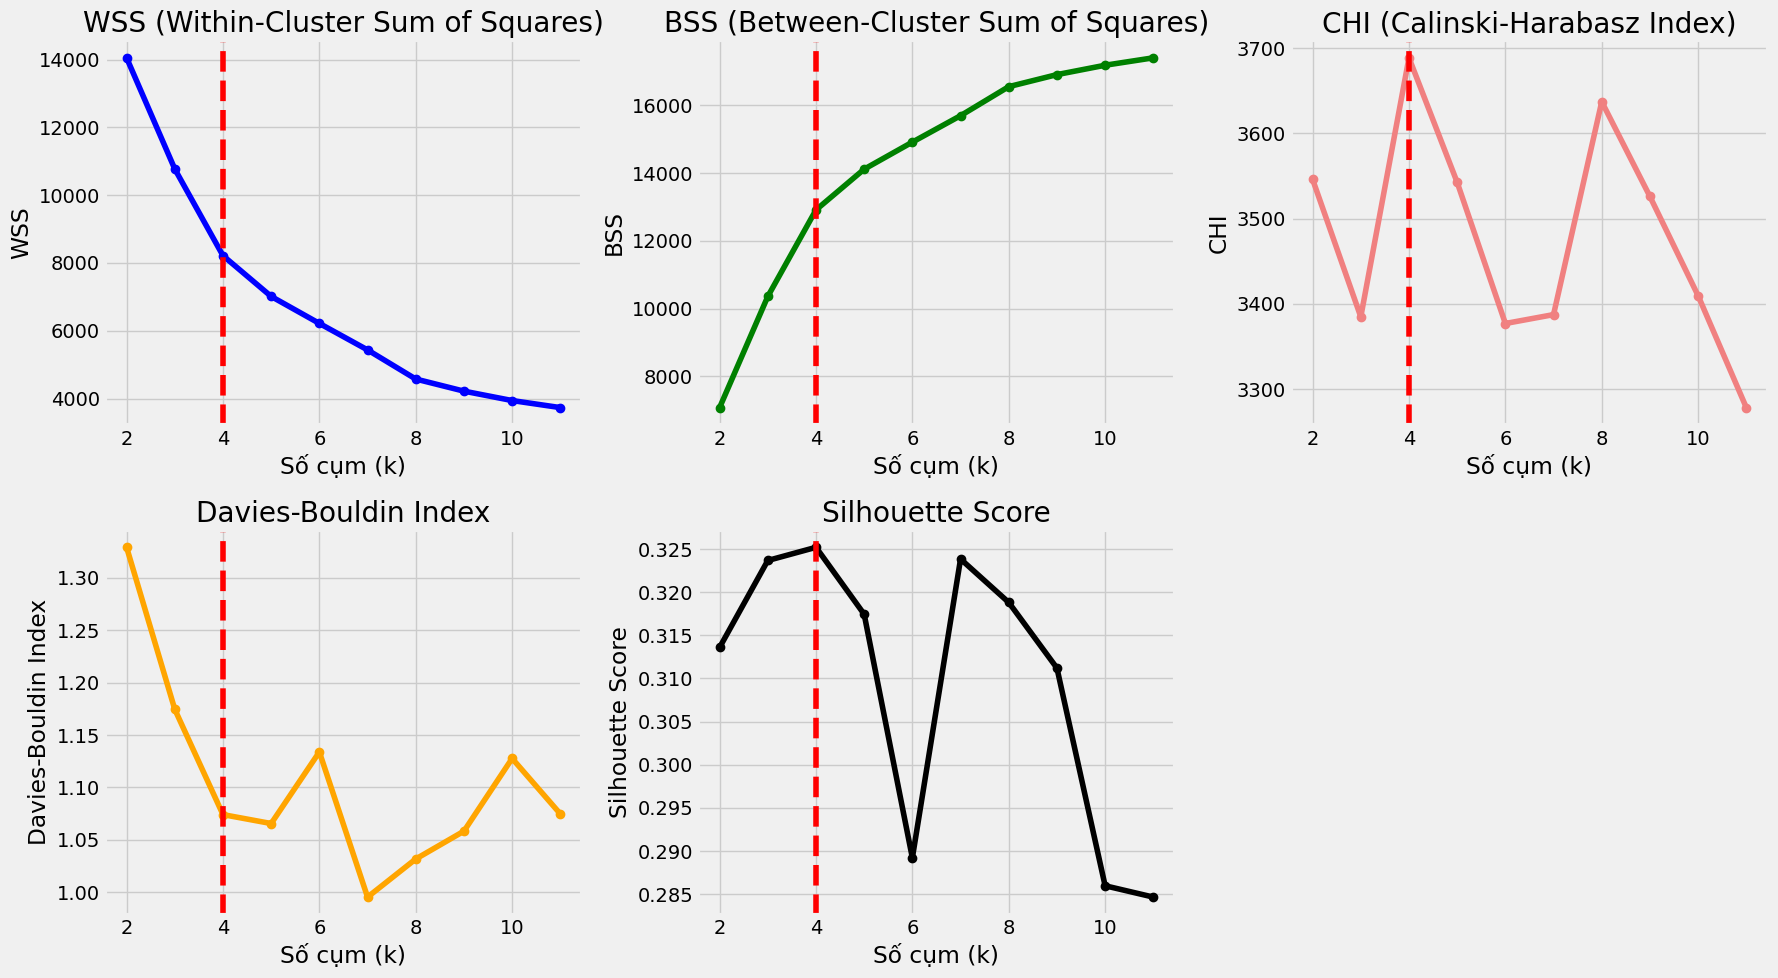

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Dữ liệu đã chuẩn hóa
X = score_normalized_data  # Sử dụng dữ liệu đã chuẩn hóa trước đó
# Tính toán các chỉ số cho k từ 2 đến 11
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(score_normalized_data)
labels = kmeans.labels_

# Tính WSS (Within-Cluster Sum of Squares) và BSS (Between-Cluster Sum of Squares)
wss = kmeans.inertia_  # Tổng bình phương trong cụm
overall_mean = np.mean(score_normalized_data, axis=0)
bss = np.sum([len(score_normalized_data[labels == i]) * np.sum((center - overall_mean) ** 2) 
              for i, center in enumerate(kmeans.cluster_centers_)])

# In kết quả WSS và BSS
print(f'WSS (Within-Cluster Sum of Squares): {wss:.4f}')
print(f'BSS (Between-Cluster Sum of Squares): {bss:.4f}')

# Tính Silhouette Score
sil_score = silhouette_score(score_normalized_data, labels)
print(f'Silhouette Score for K = 4: {sil_score:.4f}')

# Tính Calinski-Harabasz Index
ch_score = calinski_harabasz_score(score_normalized_data, labels)
print(f'Calinski-Harabasz Index for K = 4: {ch_score:.4f}')

# Tính Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(score_normalized_data, labels)
print(f'Davies-Bouldin Index for K = 4: {davies_bouldin:.4f}')
# Lưu trữ các chỉ số cho các giá trị k từ 2 đến 11
wss_list = []
bss_list = []
silhouette_list = []
calinski_harabasz_list = []
davies_bouldin_list = []

# Tính toán các chỉ số cho k từ 2 đến 11
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    
    # Tính WSS (Within-Cluster Sum of Squares)
    wss_list.append(kmeans.inertia_)
    
    # Tính BSS (Between-Cluster Sum of Squares)
    overall_mean = np.mean(X, axis=0)
    bss = np.sum([len(X[labels == i]) * np.sum((center - overall_mean) ** 2) 
                  for i, center in enumerate(kmeans.cluster_centers_)])
    bss_list.append(bss)
    
    # Tính Silhouette Score
    sil_score = silhouette_score(X, labels)
    silhouette_list.append(sil_score)
    
    # Tính Calinski-Harabasz Index
    ch_score = calinski_harabasz_score(X, labels)
    calinski_harabasz_list.append(ch_score)
    
    # Tính Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(X, labels)
    davies_bouldin_list.append(davies_bouldin)

# Vẽ biểu đồ cho tất cả các chỉ số
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# WSS
axs[0, 0].plot(range(2, 12), wss_list, marker='o', color='blue', label='WSS')
axs[0, 0].axvline(x=4, color='red', linestyle='--')
axs[0, 0].set_title('WSS (Within-Cluster Sum of Squares)')
axs[0, 0].set_xlabel('Số cụm (k)')
axs[0, 0].set_ylabel('WSS')
axs[0, 0].grid(True)

# BSS
axs[0, 1].plot(range(2, 12), bss_list, marker='o', color='green', label='BSS')
axs[0, 1].axvline(x=4, color='red', linestyle='--')
axs[0, 1].set_title('BSS (Between-Cluster Sum of Squares)')
axs[0, 1].set_xlabel('Số cụm (k)')
axs[0, 1].set_ylabel('BSS')
axs[0, 1].grid(True)
# CHI
axs[0, 2].plot(range(2, 12), calinski_harabasz_list, marker='o', color='lightcoral', label='CHI')
axs[0, 2].axvline(x=4, color='red', linestyle='--')
axs[0, 2].set_title('CHI (Calinski-Harabasz Index)')
axs[0, 2].set_xlabel('Số cụm (k)')
axs[0, 2].set_ylabel('CHI')
axs[0, 2].grid(True)

# Davies-Bouldin Index với độ chia y = 0.1
axs[1, 0].plot(range(2, 12), davies_bouldin_list, marker='o', color='orange', label='Davies-Bouldin Index')
axs[1, 0].axvline(x=4, color='red', linestyle='--')
axs[1, 0].set_title('Davies-Bouldin Index')
axs[1, 0].set_xlabel('Số cụm (k)')
axs[1, 0].set_ylabel('Davies-Bouldin Index')
axs[1, 0].grid(True)

# Silhouette Score
axs[1, 1].plot(range(2, 12), silhouette_list, marker='o', color='black', label='Silhouette Score')
axs[1, 1].axvline(x=4, color='red', linestyle='--')
axs[1, 1].set_title('Silhouette Score')
axs[1, 1].set_xlabel('Số cụm (k)')
axs[1, 1].set_ylabel('Silhouette Score')
axs[1, 1].grid(True)

# Loại bỏ subplot trống
axs[1, 2].axis('off')

# Điều chỉnh bố cục và hiển thị
fig.tight_layout()



+ Ma trận khoảng các giữa các cụm

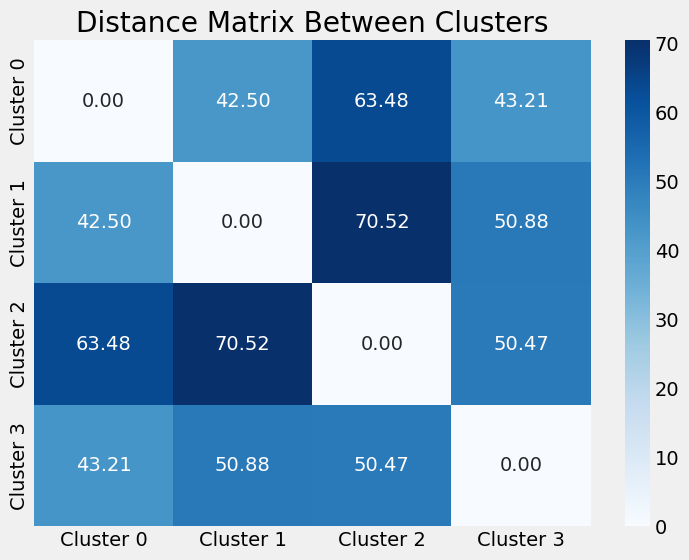

In [ ]:

from scipy.spatial.distance import pdist, squareform

# Tính tọa độ trung bình (tâm cụm) cho mỗi cụm
centroids = data.groupby('Cluster')[['Age', 'tenure', 'MonthlyCharges']].mean()

# Tính khoảng cách giữa các tâm cụm
distance_matrix = pdist(centroids, metric='euclidean')  # Sử dụng khoảng cách Euclidean
distance_matrix = squareform(distance_matrix)  # Chuyển thành dạng ma trận vuông

# Tạo DataFrame để dễ hiển thị
distance_df = pd.DataFrame(distance_matrix, 
                           index=[f'Cluster {i}' for i in centroids.index], 
                           columns=[f'Cluster {i}' for i in centroids.index])

# Vẽ heatmap của ma trận khoảng cách
plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, fmt=".2f", cmap='Blues', cbar=True)
plt.title("Distance Matrix Between Clusters")
plt.show()


+ Boxplot mô tả phân bố của các cụm

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4216\2331357346.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4216\2331357346.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4216\2331357346.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




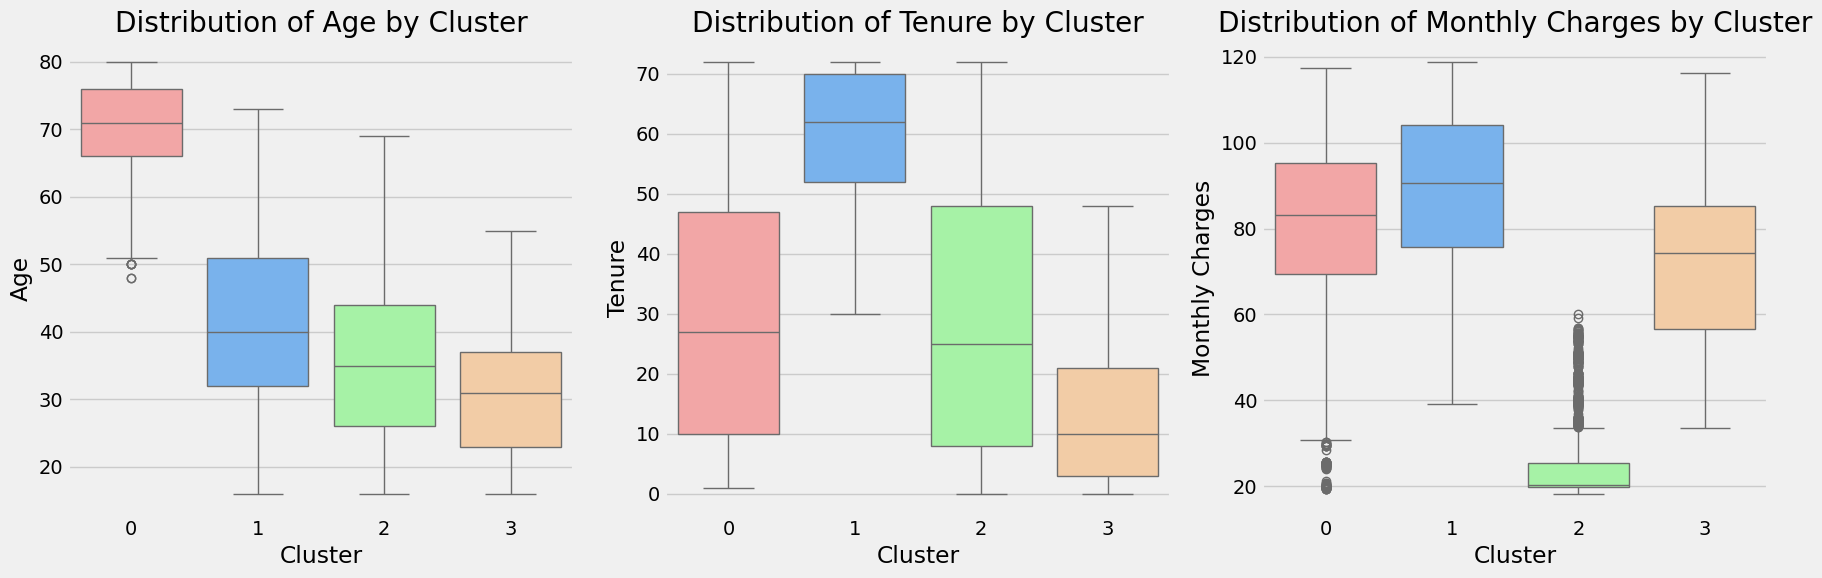

In [39]:
# Định nghĩa bảng màu tùy chỉnh cho từng cụm
palette_custom = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]  # Màu sắc theo cluster

# Thiết lập kích thước tổng thể
plt.figure(figsize=(18, 6))

# Biểu đồ boxplot cho 'Age'
plt.subplot(1, 3, 1)
sns.boxplot(x="Cluster", y="Age",data=data, palette=palette_custom)
plt.title("Distribution of Age by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Age")

# Biểu đồ boxplot cho 'Tenure'
plt.subplot(1, 3, 2)
sns.boxplot(x="Cluster", y="tenure",data=data, palette=palette_custom)
plt.title("Distribution of Tenure by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Tenure")

# Biểu đồ boxplot cho 'MonthlyCharges'
plt.subplot(1, 3, 3)
sns.boxplot(x="Cluster", y="MonthlyCharges", data=data, palette=palette_custom)
plt.title("Distribution of Monthly Charges by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Monthly Charges")

# Tinh chỉnh hiển thị
plt.tight_layout()
plt.show()


## 2. Thuật toán Hierachical

### a. Biểu đồ Dendrogram - biểu đồ Silhouette chọn số cụm

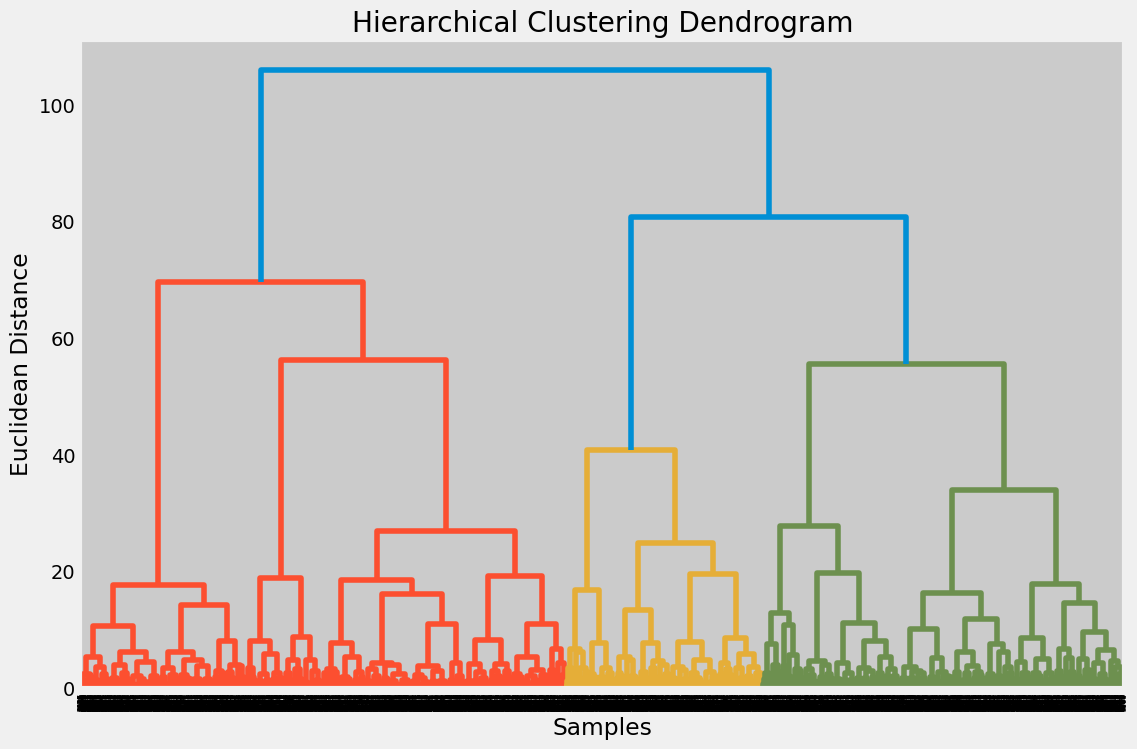

In [59]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
# Tạo dendrogram sử dụng phương pháp Ward
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(sch.linkage(score_normalized_data, method='ward'))

# Thêm tiêu đề và nhãn
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.show()


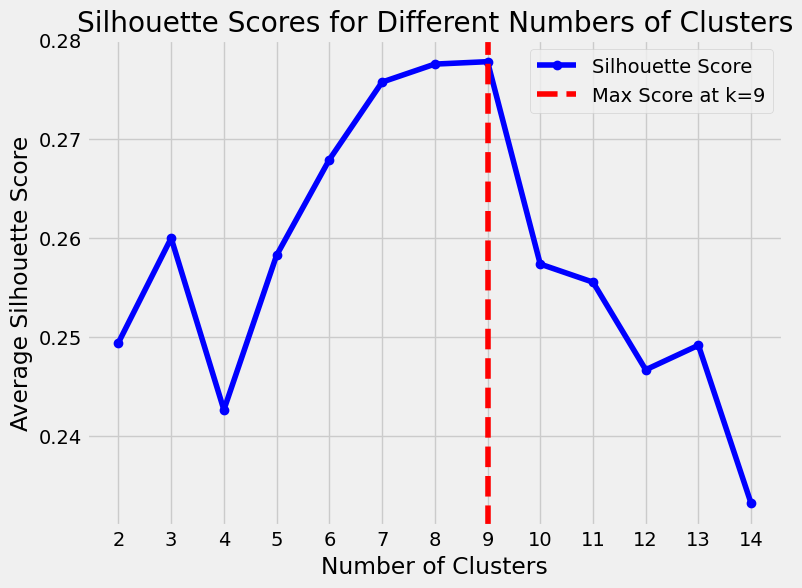

In [46]:
# Danh sách số cụm để kiểm tra
cluster_range = range(2, 15)  # Kiểm tra từ 2 đến 14 cụm
silhouette_avg_scores = []
# Lặp qua các số cụm và tính điểm silhouette trung bình
for n_clusters in cluster_range:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = agg_clustering.fit_predict(score_normalized_data)
    silhouette_avg = silhouette_score(score_normalized_data, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)

# Xác định số cụm có silhouette cao nhất
best_n_clusters = cluster_range[silhouette_avg_scores.index(max(silhouette_avg_scores))]

# Vẽ biểu đồ đường Silhouette
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_avg_scores, marker='o', linestyle='-', color='b', label='Silhouette Score')
plt.axvline(x=best_n_clusters, color='red', linestyle='--', label=f'Max Score at k={best_n_clusters}')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.legend()
plt.show()

### b. Thực hiện phân cụm Hierachical với K=6

In [60]:
agg_clustering = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')
labels = agg_clustering.fit_predict(score_normalized_data)
# Gắn nhãn cụm vào dữ liệu gốc
data['Cluster'] = labels
# Hiển thị số dòng trong từng cụm
print(data['Cluster'].value_counts())

Cluster
1    1657
2    1514
0    1324
3    1119
5     921
4     508
Name: count, dtype: int64


In [ ]:
# Tính WSS (Within-Cluster Sum of Squares)
def calculate_wss(data, labels):
    wss = 0
    for label in np.unique(labels):
        cluster_points = data[labels == label]
        cluster_center = cluster_points.mean(axis=0)
        wss += np.sum((cluster_points - cluster_center) ** 2)
    return wss

# Tính BSS (Between-Cluster Sum of Squares)
def calculate_bss(data, labels):
    overall_mean = data.mean(axis=0)
    bss = 0
    for label in np.unique(labels):
        cluster_points = data[labels == label]
        cluster_center = cluster_points.mean(axis=0)
        bss += len(cluster_points) * np.sum((cluster_center - overall_mean) ** 2)
    return bss

# Tính các chỉ số
wss = calculate_wss(score_normalized_data, labels)
bss = calculate_bss(score_normalized_data, labels)
chi = calinski_harabasz_score(score_normalized_data, labels)
db = davies_bouldin_score(score_normalized_data, labels)
silhouette_avg = silhouette_score(score_normalized_data, labels)

# Hiển thị kết quả
print(f"WSS (Within-Cluster Sum of Squares): {wss}")
print(f"BSS (Between-Cluster Sum of Squares): {bss}")
print(f"Calinski-Harabasz Index (CHI): {chi}")
print(f"Davies-Bouldin Index (DB): {db}")
print(f"Silhouette Score: {silhouette_avg}")

WSS (Within-Cluster Sum of Squares): 6737.341186718682
BSS (Between-Cluster Sum of Squares): 14391.658813281298
Calinski-Harabasz Index (CHI): 3006.352217064562
Davies-Bouldin Index (DB): 1.039491295093853
Silhouette Score: 0.2679183140624683


### c. Biểu đồ phân tán của các cụm

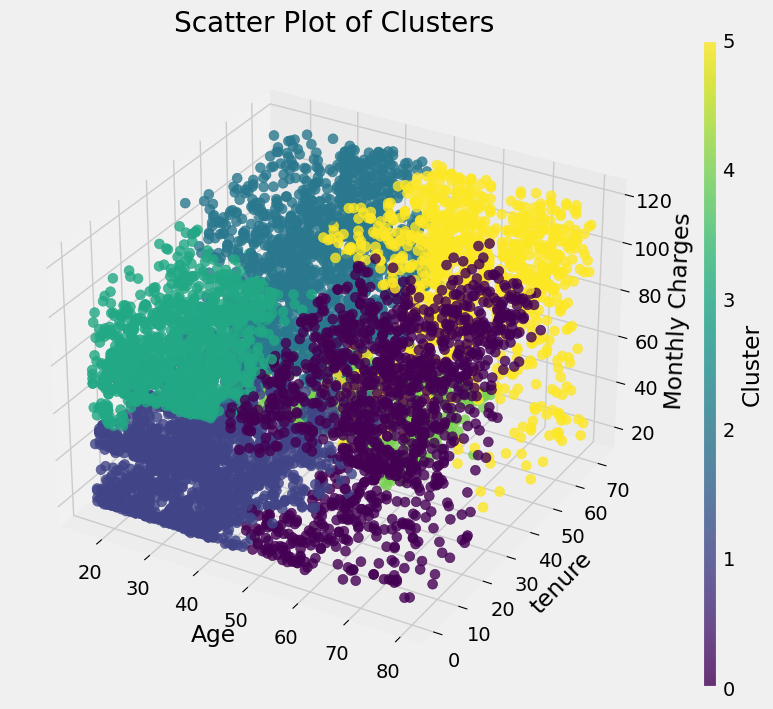

In [49]:
# Tạo biểu đồ 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ từng cụm theo màu
scatter = ax.scatter(
    data['Age'], 
    data['tenure'], 
    data['MonthlyCharges'], 
    c=data['Cluster'],   # Màu theo cụm
    cmap='viridis',      # Dùng bảng màu
    s=50,                # Kích thước điểm
    alpha=0.8            # Độ trong suốt
)
# Gắn nhãn các trục
ax.set_xlabel('Age')
ax.set_ylabel('tenure')
ax.set_zlabel('Monthly Charges')
# Thêm tiêu đề
ax.set_title('Scatter Plot of Clusters')
# Hiển thị thanh màu (legend)
cbar = fig.colorbar(scatter, ax=ax, ticks=[0, 1, 2, 3, 4, 5], aspect=40)  # Chỉ định các giá trị cụ thể
cbar.set_label('Cluster')
# Hiển thị biểu đồ
plt.show()

trace1 = go.Scatter3d(
    x= data['Age'],
    y= data['tenure'],
    z= data['MonthlyCharges'],
    mode='markers',
    marker=dict(
        size=7,  # Kích thước điểm nhỏ
        color=data['Cluster'],  
        colorscale='Viridis', 
        colorbar=dict(title='Cluster'),
        line=dict(width=0),  # Không viền
        opacity=0.8
    )
)
data = [trace1]
layout = go.Layout(
    title='Clusters ',
    width=650,  # Chiều rộng của biểu đồ
    height=600,  # Chiều cao của biểu đồ
    scene=dict(
        xaxis=dict(title='Age'),
        yaxis=dict(title='tenure'),
        zaxis=dict(title='MonthlyCharges')
    )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [62]:
data.head(10)

customerID  gender  SeniorCitizen Partner Dependents  Age  tenure  \
0  7590-VHVEG  Female              0     Yes         No   34       1   
1  5575-GNVDE    Male              0      No         No   27      34   
2  3668-QPYBK    Male              0      No         No   36       2   
3  7795-CFOCW    Male              0      No         No   27      45   
4  9237-HQITU  Female              0      No         No   25       2   
5  9305-CDSKC  Female              0      No         No   23       8   
6  1452-KIOVK    Male              0      No        Yes   16      22   
7  6713-OKOMC  Female              0      No         No   24      10   
8  7892-POOKP  Female              0     Yes         No   56      28   
9  6388-TABGU    Male              0      No        Yes   16      62   

  PhoneService     MultipleLines InternetService  ... StreamingMovies  \
0           No  No phone service             DSL  ...              No   
1          Yes                No             DSL  ...              No   
2          Yes                No             DSL  ...              No   
3           No  No phone service             DSL  ...              No   
4          Yes                No     Fiber optic  ...              No   
5          Yes               Yes     Fiber optic  ...             Yes   
6          Yes               Yes     Fiber optic  ...              No   
7           No  No phone service             DSL  ...              No   
8          Yes               Yes     Fiber optic  ...             Yes   
9          Yes                No             DSL  ...              No   

         Contract PaperlessBilling              PaymentMethod MonthlyCharges  \
0  Month-to-month              Yes           Electronic check          29.85   
1        One year               No               Mailed check          56.95   
2  Month-to-month              Yes               Mailed check          53.85   
3        One year               No  Bank transfer (automatic)          42.30   
4  Month-to-month              Yes           Electronic check          70.70   
5  Month-to-month              Yes           Electronic check          99.65   
6  Month-to-month              Yes    Credit card (automatic)          89.10   
7  Month-to-month               No               Mailed check          29.75   
8  Month-to-month              Yes           Electronic check         104.80   
9        One year               No  Bank transfer (automatic)          56.15   

  TotalCharges numAdminTickets numTechTickets Churn  Cluster  
0        29.85               0              0    No        1  
1       1889.5               0              0    No        2  
2       108.15               0              0   Yes        1  
3      1840.75               0              3    No        2  
4       151.65               0              0   Yes        3  
5        820.5               0              0   Yes        3  
6       1949.4               0              0    No        3  
7        301.9               0              0    No        1  
8      3046.05               0              2   Yes        0  
9      3487.95               0              0    No        2  

[10 rows x 25 columns]

### d. Đánh giá chất lượng phân cụm tại K=6

+ Các chỉ số đánh giá

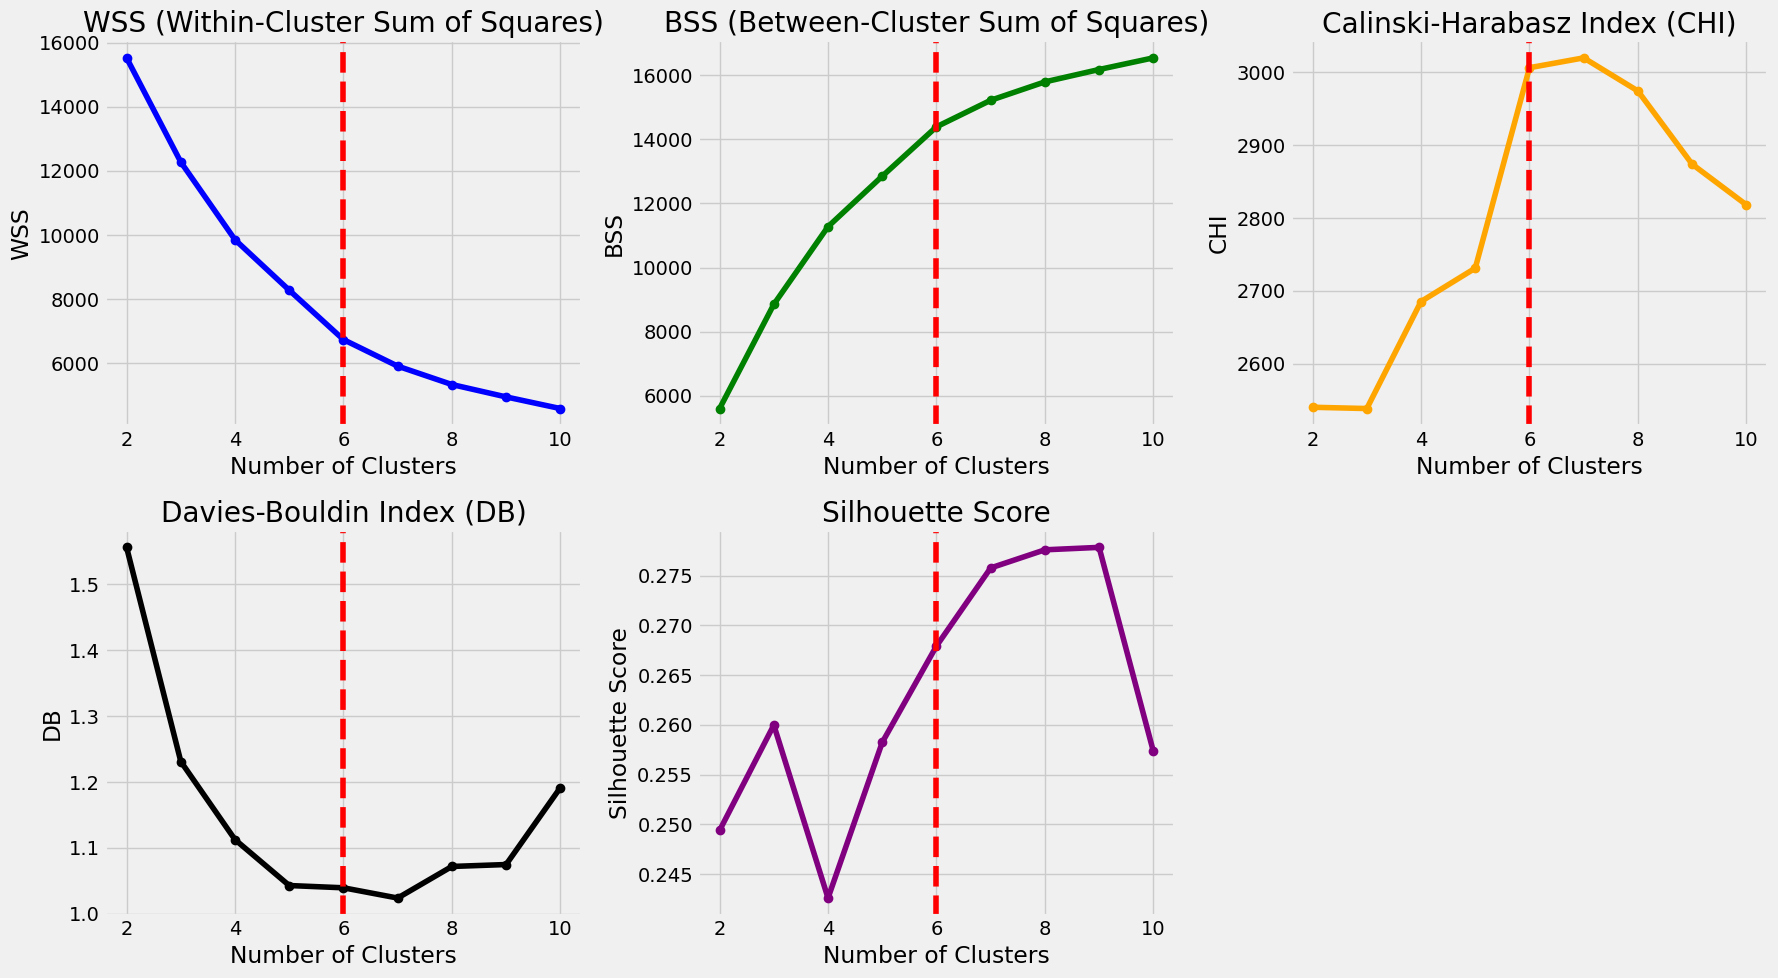

In [117]:
# Danh sách số cụm để kiểm tra
cluster_range = range(2, 11)  # Kiểm tra từ 2 đến 10 cụm
wss_values = []
bss_values = []
chi_values = []
db_values = []
silhouette_values = []

# Lặp qua các số cụm và tính các chỉ số
for n_clusters in cluster_range:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = agg_clustering.fit_predict(score_normalized_data)
    
    # Tính các chỉ số cho mỗi số cụm
    wss = calculate_wss(score_normalized_data, cluster_labels)
    bss = calculate_bss(score_normalized_data, cluster_labels)
    chi = calinski_harabasz_score(score_normalized_data, cluster_labels)
    db = davies_bouldin_score(score_normalized_data, cluster_labels)
    silhouette_avg = silhouette_score(score_normalized_data, cluster_labels)

    # Thêm các giá trị vào danh sách
    wss_values.append(wss)
    bss_values.append(bss)
    chi_values.append(chi)
    db_values.append(db)
    silhouette_values.append(silhouette_avg)

# Tạo các subplot để vẽ biểu đồ đường
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# WSS
axs[0, 0].plot(cluster_range, wss_values, marker='o', color='blue')
axs[0, 0].set_title('WSS (Within-Cluster Sum of Squares)')
axs[0, 0].axvline(x=6, color='red', linestyle='--')
axs[0, 0].set_xlabel('Number of Clusters')
axs[0, 0].set_ylabel('WSS')
axs[0, 0].grid(True)

# BSS
axs[0, 1].plot(cluster_range, bss_values, marker='o', color='green')
axs[0, 1].set_title('BSS (Between-Cluster Sum of Squares)')
axs[0, 1].axvline(x=6, color='red', linestyle='--')
axs[0, 1].set_xlabel('Number of Clusters')
axs[0, 1].set_ylabel('BSS')
axs[0, 1].grid(True)

# CHI (Calinski-Harabasz Index)
axs[0, 2].plot(cluster_range, chi_values, marker='o', color='orange')
axs[0, 2].set_title('Calinski-Harabasz Index (CHI)')
axs[0, 2].axvline(x=6, color='red', linestyle='--')
axs[0, 2].set_xlabel('Number of Clusters')
axs[0, 2].set_ylabel('CHI')
axs[0, 2].grid(True)

# DB (Davies-Bouldin Index)
axs[1, 0].plot(cluster_range, db_values, marker='o', color='black')
axs[1, 0].set_title('Davies-Bouldin Index (DB)')
axs[1, 0].axvline(x=6, color='red', linestyle='--')
axs[1, 0].set_xlabel('Number of Clusters')
axs[1, 0].set_ylabel('DB')
axs[1, 0].grid(True)

# Silhouette
axs[1, 1].plot(cluster_range, silhouette_values, marker='o', color='purple')
axs[1, 1].set_title('Silhouette Score')
axs[1, 1].axvline(x=6, color='red', linestyle='--')
axs[1, 1].set_xlabel('Number of Clusters')
axs[1, 1].set_ylabel('Silhouette Score')
axs[1, 1].grid(True)

# Loại bỏ subplot trống
axs[1, 2].axis('off')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


+ Boxplot

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4216\3485144999.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4216\3485144999.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4216\3485144999.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




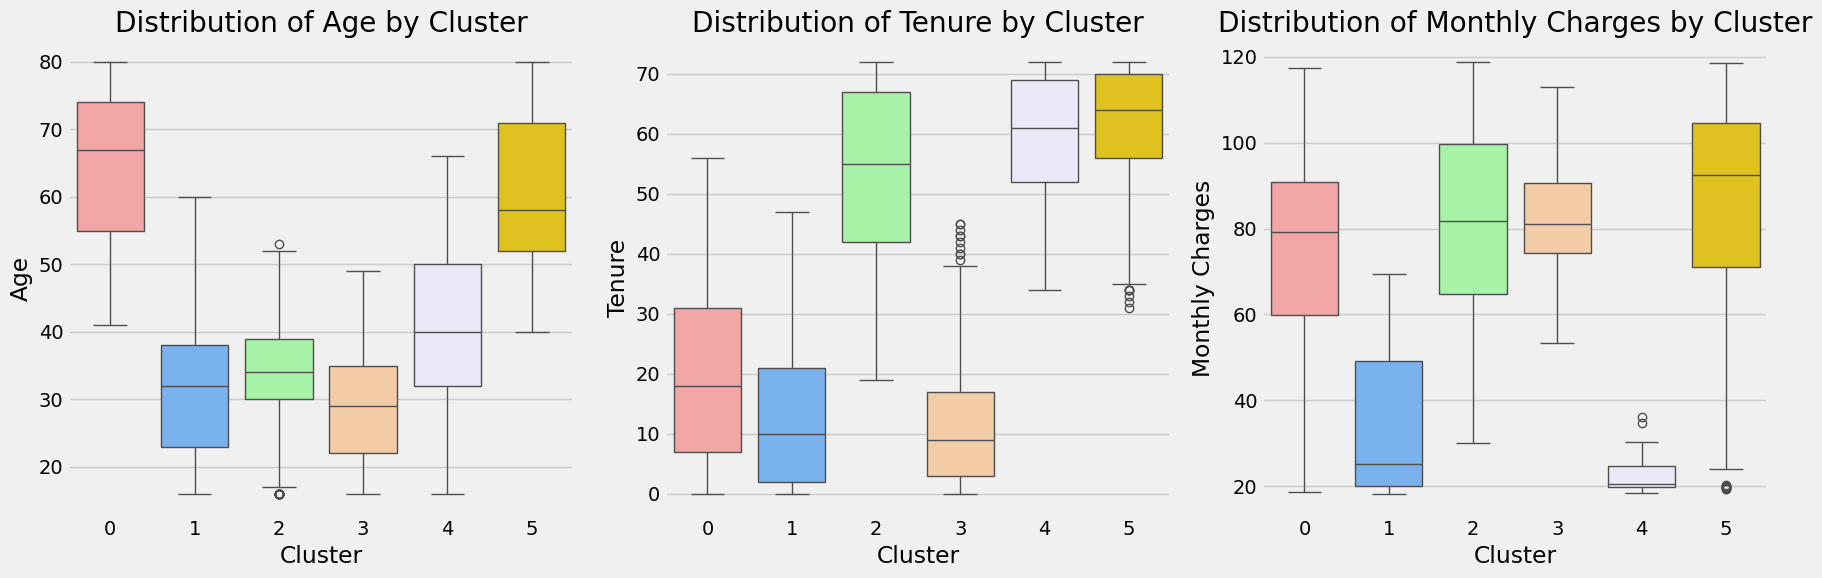

In [63]:
palette_custom = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99", "#E6E6FA", "#FFD700"]  # Màu sắc theo cluster

# Thiết lập kích thước tổng thể
plt.figure(figsize=(18, 6))

# Biểu đồ boxplot cho 'Age'
plt.subplot(1, 3, 1)
sns.boxplot(x="Cluster", y="Age", data=data, palette=palette_custom)
plt.title("Distribution of Age by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Age")

# Biểu đồ boxplot cho 'Tenure'
plt.subplot(1, 3, 2)
sns.boxplot(x="Cluster", y="tenure", data=data, palette=palette_custom)
plt.title("Distribution of Tenure by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Tenure")

# Biểu đồ boxplot cho 'MonthlyCharges'
plt.subplot(1, 3, 3)
sns.boxplot(x="Cluster", y="MonthlyCharges", data=data, palette=palette_custom)
plt.title("Distribution of Monthly Charges by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Monthly Charges")

# Tinh chỉnh hiển thị
plt.tight_layout()
plt.show()


+ Ma trận khoảng cách giữa các cụm

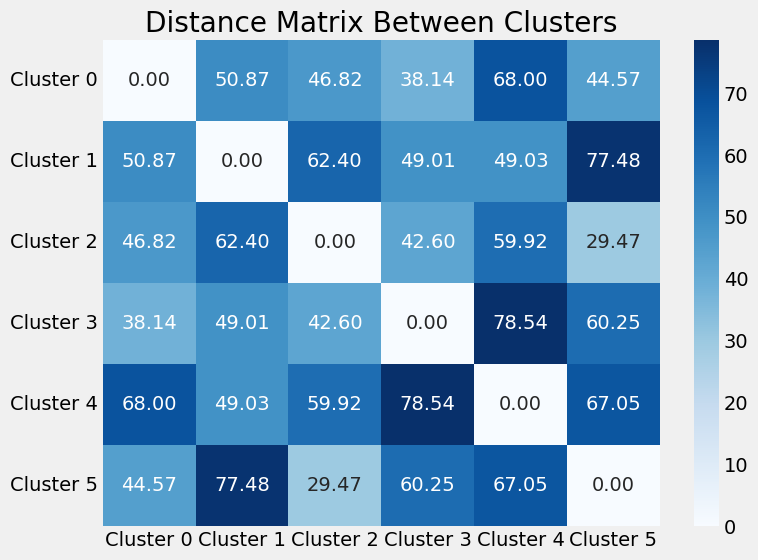

In [65]:
from scipy.spatial.distance import pdist, squareform
# Tính tọa độ trung bình (tâm cụm) cho mỗi cụm
centroids = data.groupby('Cluster')[['Age', 'tenure', 'MonthlyCharges']].mean()

# Tính khoảng cách giữa các tâm cụm
distance_matrix = pdist(centroids, metric='euclidean')  # Sử dụng khoảng cách Euclidean
distance_matrix = squareform(distance_matrix)  # Chuyển thành dạng ma trận vuông

# Tạo DataFrame để dễ hiển thị
distance_df = pd.DataFrame(distance_matrix, 
                           index=[f'Cluster {i}' for i in centroids.index], 
                           columns=[f'Cluster {i}' for i in centroids.index])

# Vẽ heatmap của ma trận khoảng cách
plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, fmt=".2f", cmap='Blues', cbar=True)
plt.title("Distance Matrix Between Clusters")
plt.show()


## 3. Thuật toán DBSCAN

### a. Xây dựng biểu đồ KNN - Xác định khoảng Epsilon

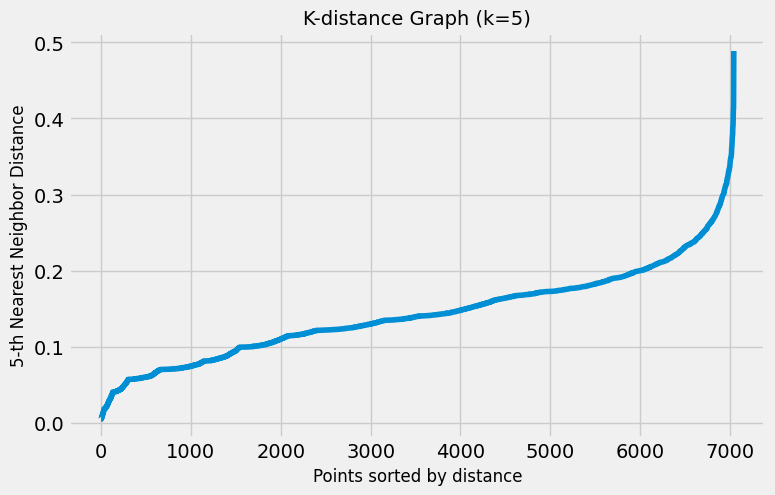

In [103]:
# Tính khoảng cách k-nearest (k = min_samples - 1 = 5)
k = 5
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(score_normalized_data)
distances, indices = nearest_neighbors.kneighbors(score_normalized_data)

# Sắp xếp khoảng cách theo thứ tự tăng dần
distances = np.sort(distances[:, k-1])
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-distance Graph (k=5)', fontsize=14)
plt.xlabel('Points sorted by distance', fontsize=12)
plt.ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=12)
plt.grid(True)
plt.show()


### b. Xây dựng thuật toán với 2 đặc trưng AGE - TENURE

Estimated number of clusters: 1
Estimated number of noise points: 0


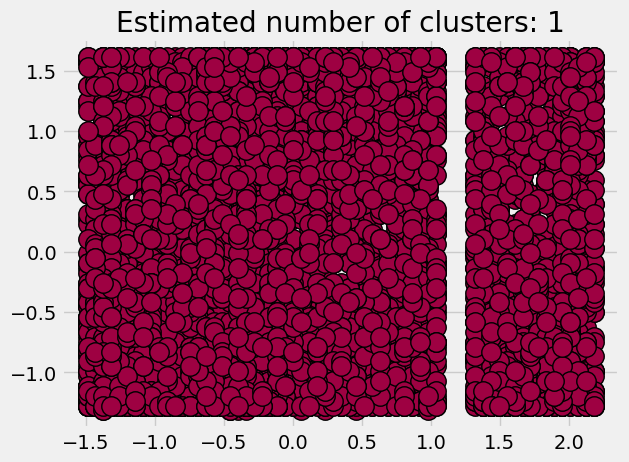

In [116]:
X1 = data[['Age', 'tenure']].iloc[: , :].values
X1 = StandardScaler().fit_transform(X1)
db = DBSCAN(eps=0.3, min_samples=6)
db.fit(X1)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Tính số lượng số cụm
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# Đánh dấu goại lai
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = X1[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    xy = X1[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### c. Xây dựng thuật toán với 2 đặc trưng TENURE - MONTHLYCHARGES

Estimated number of clusters: 1
Estimated number of noise points: 0


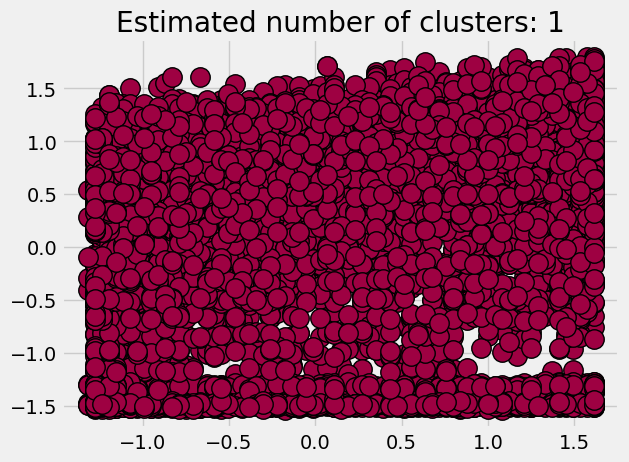

In [117]:
X2 = data[['tenure', 'MonthlyCharges']].iloc[: , :].values
X2 = StandardScaler().fit_transform(X2)
db = DBSCAN(eps=0.3, min_samples=6)

db.fit(X2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X2[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X2[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### d. Xây dựng thuật toán với 3 đặc trưng

Estimated number of clusters: 4
Estimated number of noise points: 39


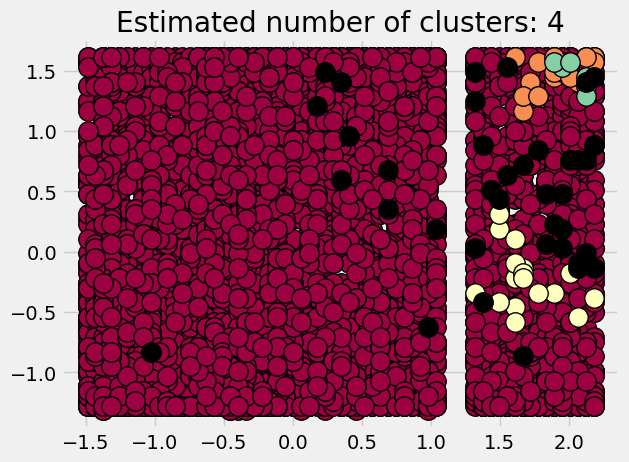

In [118]:
X3 = data[['Age' , 'tenure' ,'MonthlyCharges']].iloc[: , :].values
X3 = StandardScaler().fit_transform(X3)
db = DBSCAN(eps=0.3, min_samples=6)
db.fit(X3)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)

    xy = X1[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X1[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [119]:
# Thêm nhãn cụm vào dữ liệu
data['Cluster'] = labels
# Kiểm tra kết quả
data['Cluster'].value_counts()

Cluster
 0    6960
-1      39
 1      21
 2      17
 3       6
Name: count, dtype: int64

### e. Biểu đồ phân tán cho các cụm vừa tạo

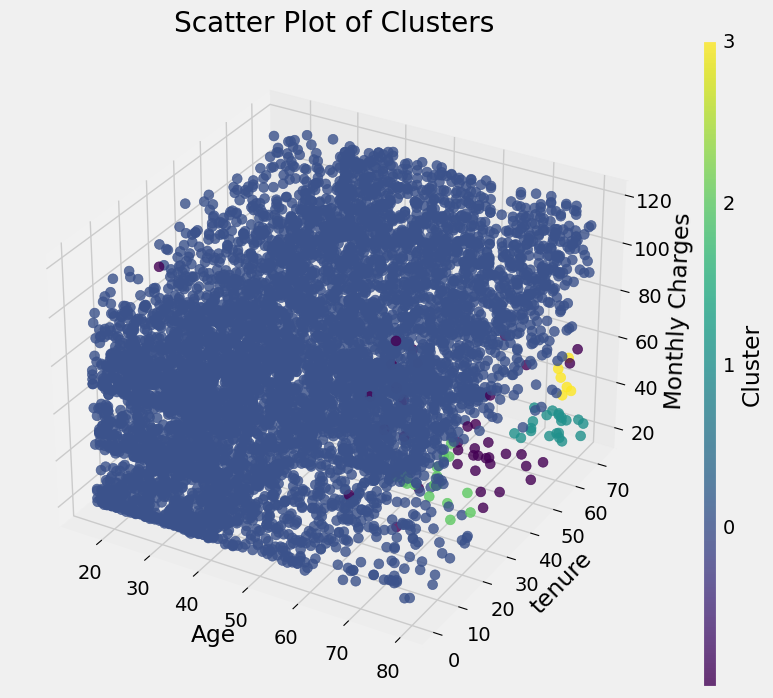

In [109]:
# Tạo biểu đồ 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ từng cụm theo màu
scatter = ax.scatter(
    data['Age'], 
    data['tenure'], 
    data['MonthlyCharges'], 
    c=data['Cluster'],   # Màu theo cụm
    cmap='viridis',      # Dùng bảng màu
    s=50,                # Kích thước điểm
    alpha=0.8            # Độ trong suốt
)
# Gắn nhãn các trục
ax.set_xlabel('Age')
ax.set_ylabel('tenure')
ax.set_zlabel('Monthly Charges')
# Thêm tiêu đề
ax.set_title('Scatter Plot of Clusters')
# Hiển thị thanh màu (legend)
cbar = fig.colorbar(scatter, ax=ax, ticks=[0, 1, 2, 3, 4, 5], aspect=40)  # Chỉ định các giá trị cụ thể
cbar.set_label('Cluster')
# Hiển thị biểu đồ
plt.show()

trace1 = go.Scatter3d(
    x= data['Age'],
    y= data['tenure'],
    z= data['MonthlyCharges'],
    mode='markers',
    marker=dict(
        size=7,  # Kích thước điểm nhỏ
        color=data['Cluster'],  
        colorscale='Viridis', 
        colorbar=dict(title='Cluster'),
        line=dict(width=0),  # Không viền
        opacity=0.8
    )
)
data = [trace1]
layout = go.Layout(
    title='Clusters ',
    width=650,  # Chiều rộng của biểu đồ
    height=600,  # Chiều cao của biểu đồ
    scene=dict(
        xaxis=dict(title='Age'),
        yaxis=dict(title='tenure'),
        zaxis=dict(title='MonthlyCharges')
    )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### f. Đánh giá phân cụm

In [122]:
# Lọc dữ liệu để loại bỏ các điểm nhiễu (Cluster = -1)
valid_clusters = data[data['Cluster'] != -1]

# Kiểm tra có cụm hợp lệ để tính toán
if len(valid_clusters['Cluster'].unique()) > 1:  # Silhouette Score yêu cầu ít nhất 2 cụm
    # Trích xuất các đặc trưng số và nhãn
    X_valid = valid_clusters[['Age', 'tenure', 'MonthlyCharges']]  # Thay bằng các cột đặc trưng của bạn
    labels = valid_clusters['Cluster']

    # Tính Silhouette Score
    score = silhouette_score(X_valid, labels)
    print(f"Silhouette Score: {score:.2f}")
else:
    print("Không đủ cụm hợp lệ để tính Silhouette Score.")


Silhouette Score: -0.05


# III. KẾT LUẬN

#### K - Mean là thuật toán có chỉ số đánh giá cao nhất, vì vậy mô hình này sẽ được sử dụng để tiến hành các công việc phân tích sau này.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4216\662900544.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4216\662900544.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4216\662900544.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




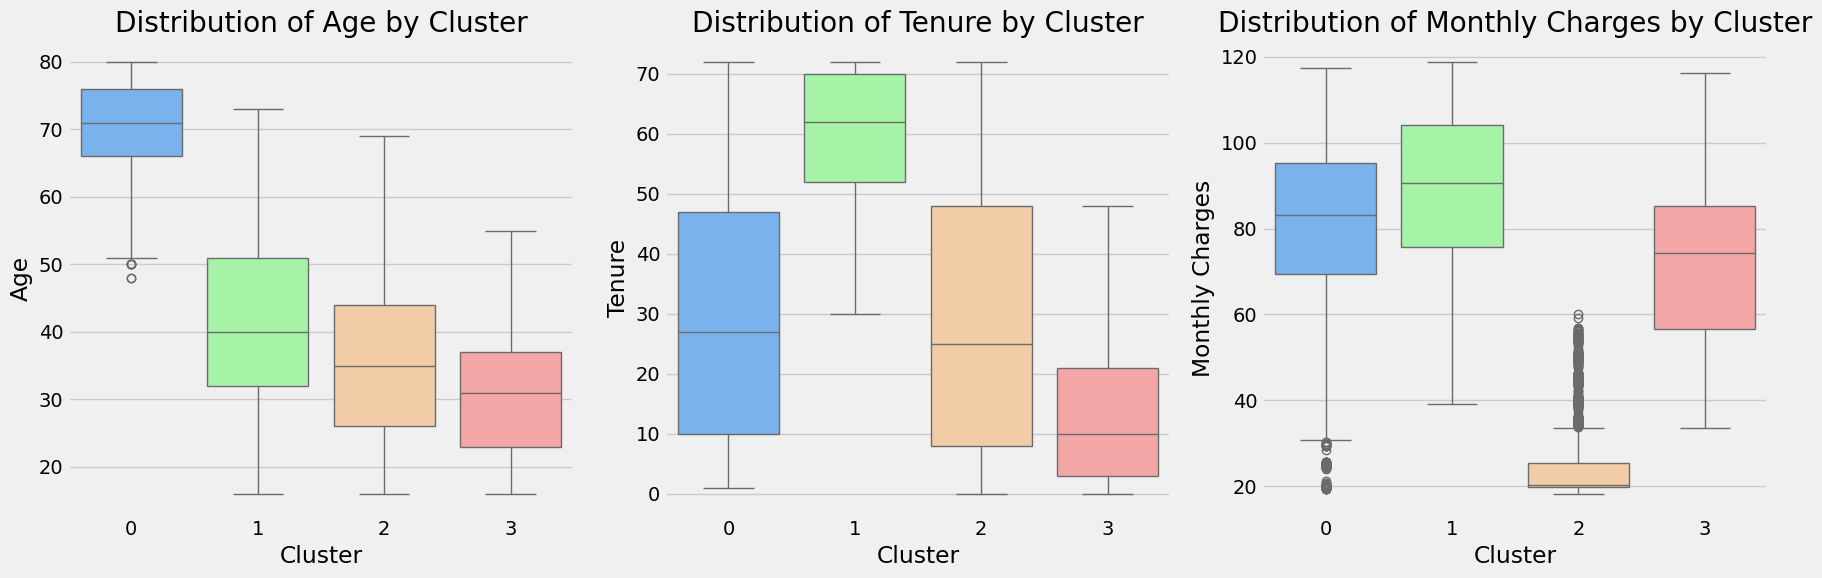

In [135]:
# Định nghĩa bảng màu tùy chỉnh cho từng cụm
palette_custom = { "#FF9999",  "#66B2FF",  "#99FF99",  "#FFCC99"}  # Màu sắc theo cluster

# Thiết lập kích thước tổng thể
plt.figure(figsize=(18, 6))

# Biểu đồ boxplot cho 'Age'
plt.subplot(1, 3, 1)
sns.boxplot(x="Cluster", y="Age", data=data, palette=palette_custom)
plt.title("Distribution of Age by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Age")

# Biểu đồ boxplot cho 'Tenure'
plt.subplot(1, 3, 2)
sns.boxplot(x="Cluster", y="tenure", data=data, palette=palette_custom)
plt.title("Distribution of Tenure by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Tenure")

# Biểu đồ boxplot cho 'MonthlyCharges'
plt.subplot(1, 3, 3)
sns.boxplot(x="Cluster", y="MonthlyCharges", data=data, palette=palette_custom)
plt.title("Distribution of Monthly Charges by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Monthly Charges")

# Tinh chỉnh hiển thị
plt.tight_layout()
plt.show()

### Tiến hành khám phá những đặc trưng khác của các cụm khách hàng.

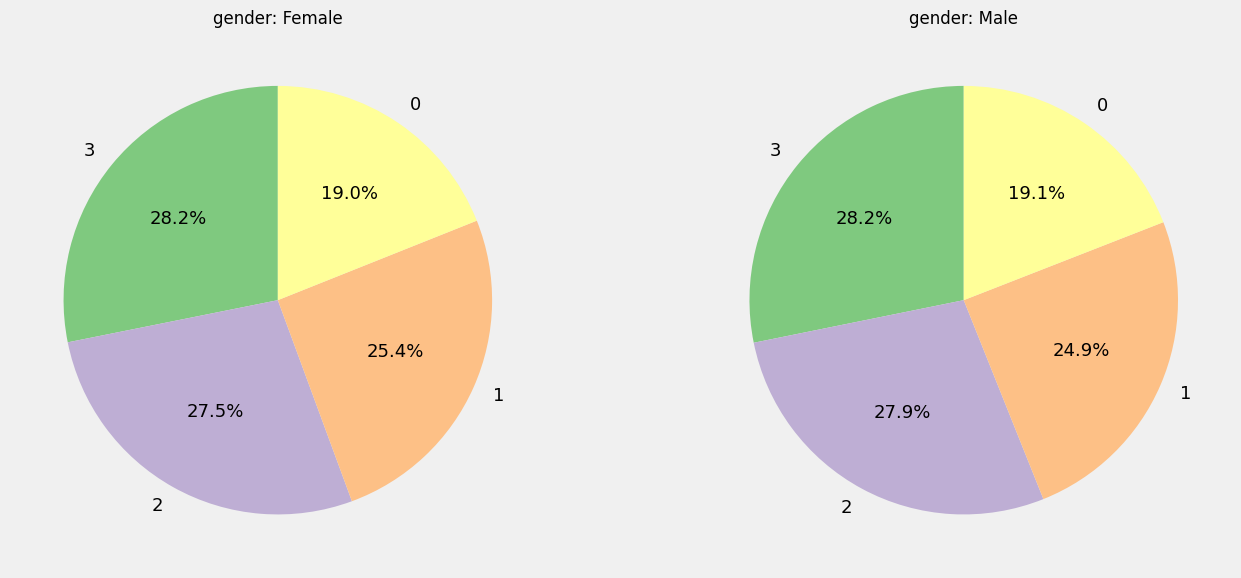

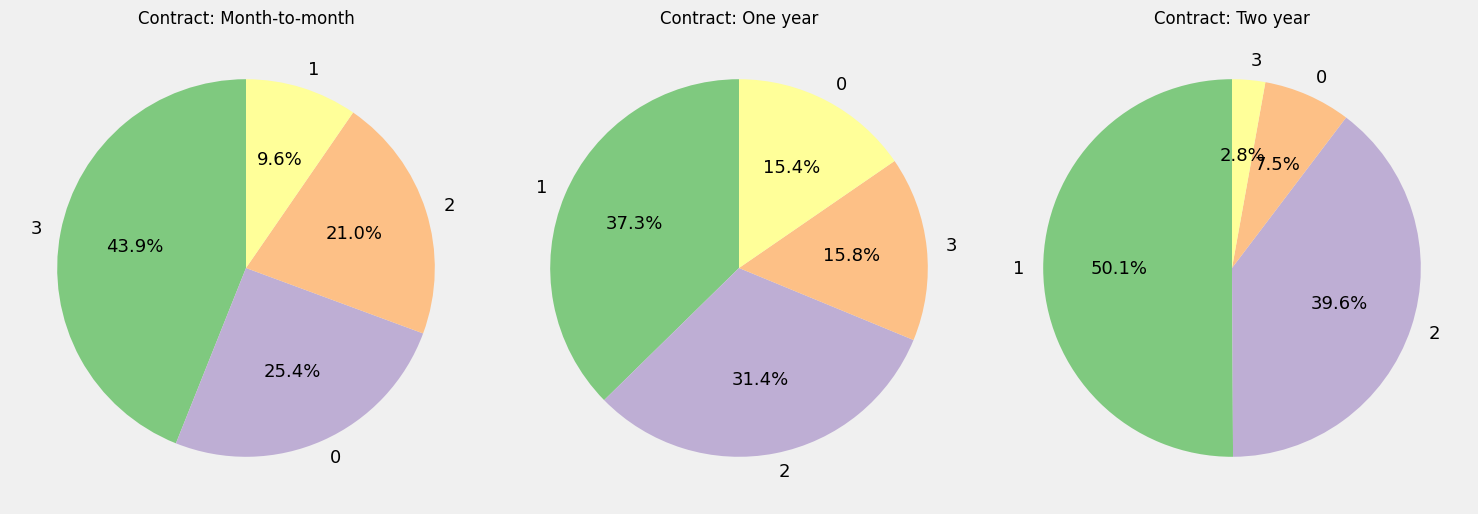

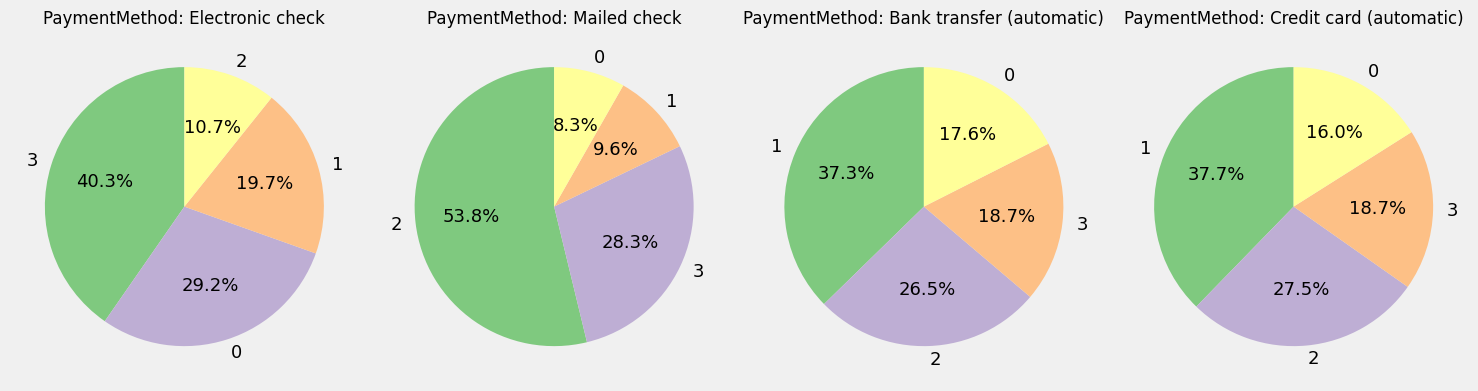

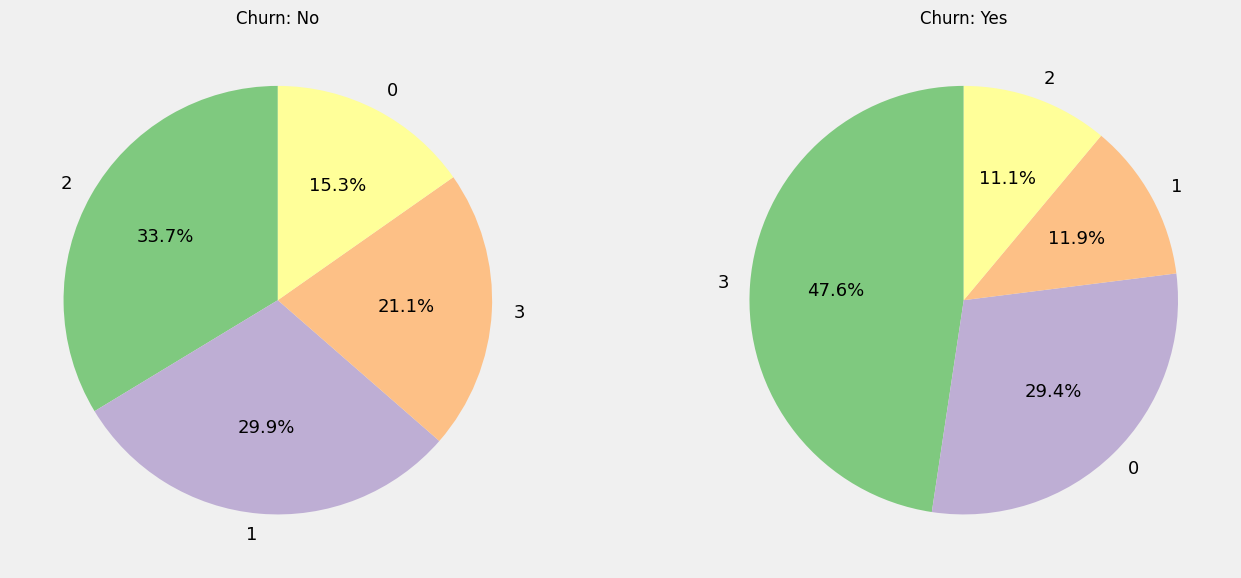

In [145]:
# Define a distinct color palette for clusters
distinct_colors = sns.color_palette("Accent", n_colors=data['Cluster'].nunique())

# Function to create pie charts with distinct colors for each cluster
def plot_distinct_pie_charts(data, column, cluster_col='Cluster', title=None):
    unique_values = data[column].unique()
    fig, axes = plt.subplots(1, len(unique_values), figsize=(15, 6))
    
    for i, value in enumerate(unique_values):
        # Filter data for the specific value and calculate proportions
        subset = data[data[column] == value][cluster_col].value_counts(normalize=True)
        
        # Plot pie chart
        axes[i].pie(subset, labels=subset.index, autopct='%1.1f%%', startangle=90, 
                    colors=distinct_colors, textprops={'fontsize': 13})
        axes[i].set_title(f"{column}: {value}", fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Generate pie charts for the specified columns with distinct colors
plot_distinct_pie_charts(data, 'gender', title="Cluster Proportion by Gender")
plot_distinct_pie_charts(data, 'Contract', title="Cluster Proportion by Contract")
plot_distinct_pie_charts(data, 'PaymentMethod', title="Cluster Proportion by Payment Method")
plot_distinct_pie_charts(data, 'Churn', title="Cluster Proportion by Churn")
